In [2]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import mido
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import midi_utils as mu
#import scales
from pretty_midi import PrettyMIDI
import sounddevice as sd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
filename = "MIDI_Files/KCP_Major_1.mid"
m = mido.MidiFile(filename=filename)
print(m.print_tracks())

=== Track 0
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('set_tempo', tempo=315789, time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('end_of_track', time=0)
=== Track 1
MetaMessage('track_name', name='harmony:Piano Full Voicing', time=0)
Message('note_on', channel=0, note=48, velocity=71, time=0)
Message('note_on', channel=0, note=55, velocity=71, time=0)
Message('note_on', channel=0, note=60, velocity=71, time=0)
Message('note_on', channel=0, note=64, velocity=71, time=0)
Message('note_off', channel=0, note=48, velocity=90, time=4094)
Message('note_off', channel=0, note=55, velocity=90, time=0)
Message('note_off', channel=0, note=60, velocity=90, time=0)
Message('note_off', channel=0, note=64, velocity=90, time=0)
Message('note_on', channel=0, note=43, velocity=71, time=2)
Message('note_on', channel=0, note=50, velocity=71, time=0)
Message('note_on', channel=0, note=59, velocity=71, t

In [4]:
music = PrettyMIDI(midi_file=filename)
print(music)

In [5]:
bla = music.synthesize(fs=22050)
sd.play(bla, 22050)

In [6]:
sd.stop()

In [11]:

def track_to_dataframe(track, event_style=False):
    records = []
    track_name = ""
    current_time = 0
    # Event style dataframe
    if event_style:
        for x in track:
            new_dict = x.__dict__.copy()
            if not x.is_meta():
                #Swapping name for coherence
                new_dict["time_diff"] = new_dict["time"] 
                current_time += new_dict["time_diff"]
                new_dict["time"] = current_time
                new_dict["pressed"] = new_dict["type"] == "note_on"
                new_dict["released"] = new_dict["type"] == "note_off"
                records.append(new_dict)
    else:
        # Streaming style dataframe
        pressed_notes = {}
        id = 0
        for x in track:
            new_dict = x.__dict__.copy()
            if new_dict["type"] == "track_name":
                track_name = new_dict["name"]
            else:
                current_time += new_dict["time"]
                new_dict["time"] = current_time
                new_dict["time_release"] = None
                new_dict["time_duration"] = None
                new_dict["velocity_release"] = None
                if new_dict["type"] == "note_off":
                    former_pressed_note = pressed_notes[new_dict["note"]]
                    if former_pressed_note is None:
                        raise ValueError("The given track has a released note that was never pressed in the first place")
                    pressed_record = records[former_pressed_note["id"]]
                    pressed_record["time_release"] = current_time
                    pressed_record["time_duration"] = current_time - pressed_record["time"]
                    pressed_record["velocity_release"] = new_dict["velocity"]
                    pressed_notes[new_dict["note"]] = None
                elif new_dict["type"] == "note_on":
                    pressed_notes[new_dict["note"]] = {"id": id}
                    del new_dict["type"]
                    records.append(new_dict)
                    id += 1
                                        
    return pd.DataFrame(records)

In [12]:
def plot_music(scheduled_style_df: pd.DataFrame, chroma_plot=False, ax=None, cmap=plt.get_cmap("gist_rainbow")):
    if ax is None:
        _, ax = plt.subplots()
    
    df_copy = scheduled_style_df[["time", "note", "time_duration", "time_release"]]
    if chroma_plot:
        df_copy.loc[:, "note"] = mu.to_chroma(df_copy["note"])
    for i, x in df_copy.iterrows():
        rect = patches.Rectangle((x.time, x.note - 0.5), width=x.time_duration, height=1, linewidth=0.2, edgecolor=(0,0,0), facecolor=cmap(x.note))
        ax.add_patch(rect)
    plt.xlim(0, df_copy.time_release.max())
    plt.ylim(df_copy.note.min() - 3, df_copy.note.max() + 3)

In [14]:
pd_track = track_to_dataframe(m.tracks[1])
print(pd_track)

     time  note  velocity  channel  time_release  time_duration  \
0       0    48        71        0          4094           4094   
1       0    55        71        0          4094           4094   
2       0    60        71        0          4094           4094   
3       0    64        71        0          4094           4094   
4    4096    43        71        0          8190           4094   
5    4096    50        71        0          8190           4094   
6    4096    59        71        0          8190           4094   
7    4096    67        71        0          8190           4094   
8    8192    45        71        0         12286           4094   
9    8192    52        71        0         12286           4094   
10   8192    60        71        0         12286           4094   
11   8192    64        71        0         12286           4094   
12  12288    41        71        0         16382           4094   
13  12288    57        71        0         16382           409

/Users/manon/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


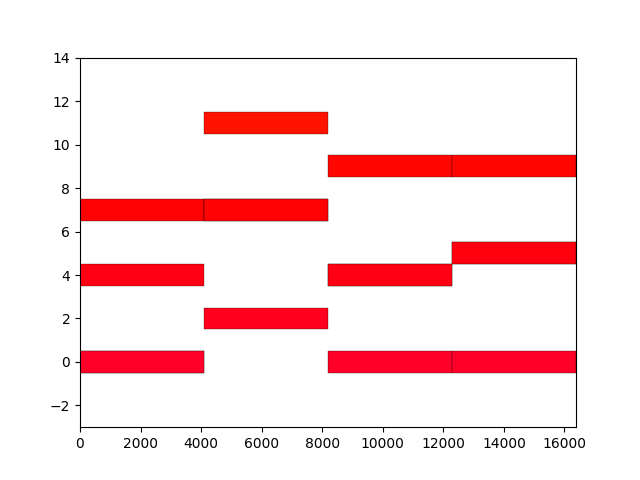

In [15]:
plot_music(pd_track, chroma_plot=True)

In [15]:
midi_ids = pd_track.note.to_numpy()

# Transposition:
midi_ids += 0


tonic_chroma = scales.music_to_tonic_chroma(midi_ids) # THIS FUNCTION IS BAD FOR THE MOMENT
print(tonic_chroma)
shifts = scales.music_to_chroma_shifts(midi_ids=midi_ids, tonic_chroma=tonic_chroma)
print(shifts)


[2 3 2 1 4 1 3]
7
[2 2 2 1 2 2 1]


In [44]:
# scale_selection = [scales.diatonic_scale(c) for c in range(12)] \
#                   + [scales.diatonic_scale(c, scales.Mode.MINOR) for c in range(12)] \
#                   + [scales.harmonic_scale(c, major=True) for c in range(12)] \
#                   + [scales.harmonic_scale(c, major=False) for c in range(12)] \
#                   + [scales.melodic_scale(c, major=True) for c in range(12)] \
#                   + [scales.melodic_scale(c, major=False) for c in range(12)] \
#                   + [scales.altered_scale(c) for c in range(12)] \
#                   + [scales.gipsy_major_scale(c) for c in range(12)] \
#                   + [scales.neapolitan_minor_scale(c) for c in range(12)] 

# for s in scale_selection:
#     score = s.compute_match(midi_ids)
#     print(s, ":", score)

['music_to_chroma_shifts' 'chromatic_shifts' 'ditetrachordic_shifts'
 'diatonic_shifts' 'harmonic_major_shifts' 'harmonic_minor_shifts'
 'melodic_major_shifts' 'melodic_minor_shifts' 'gipsy_major_shifts'
 'neapolitan_minor_shifts' 'altered_shifts' 'diatonic_shifts']
